# Data Balancing

**Author: [Kevin Broløs](https://abzu.ai/team)**

This notebook will go through balancing datasets.
It's mostly used for classification, though there are also methods for regression, but they are a bit more advanced and out of scope for this course.

Usually, you consider balancing for classification with respect to the output variable. There are definitely balancing issues to consider for your input features as well (as hinted at during analysis and preparation, you want your data columns to be representative of the true distribution, whatever it may be), but we are going to only look at how to prepare your dataset to avoid skewing learning towards a single class.

# Sampling methods

It is most commonly fixed when splitting and sampling your data prior to training. There are a few commonly used methods for this. There are also some advanced methods like SMOTE, which we will not go into here, but is an excellent follow-up topic once you've understood these.

## What is sampling?

Sampling refers to the process of picking the individual samples (data points) from your data set. It comes from statistical terms of sampling a distribution. You can do so randomly, with or without replacement, entirely, or using some more clever approaches as we will describe.

The result will be that the new sampled set will have a different representation and you want that to be as fair as possible for modelling.

Consider a binary classification dataset (a dataset with two output classes).

Let's call this: 
### Case 1
If one of the classes make up 25% of the dataset and the other class 75% of the dataset, we would consider it unbalanced. It could be represented like this:
**\[25, 75\]**. 

In this case, class 1 would be the minority class and class 2 the majority class.

You can also have something like:
### Case 2
You can also have three classes, with the distribution, for example: 

**\[15, 35, 50\]**, 

which has two minority classes and one majority.

And of course many more.

Both of these cases would skew the learning towards the majority class, as that class has more points that influence the model than the remaining cases. In short, the model learns more about that class than the rest.

An unbalanced problem also means that just always guessing the majority class would give a 75% and 50% success rate on the model, respectively for the two cases.

## Oversampling

Oversampling is the process of sampling the minority class **more** times, with replacement, to get it up to the same level as the majority class. So if we take case 1: \[25, 75\]

You would sample class 2 entirely - so 75 samples. You would then either:
* Sample class 1 entirely - 3 times - to get to 75 (you can calculate this ratio for automation)
* Sample class 1 75 times with replacement to get up to the same representation

In both cases, you now end up with a 150 samples instead of the original 100, as the minority class has duplicated samples to ensure the model learns evenly from both. Which one of these you prefer to use could be decided from some consideration of the sparsity of the data, and whether you trust you'll get a good distribution out of sampling it versus repeating it.
Sampling is generally preferred as you don't make decisions on ordering of data - however there are cases where you can decide to repeat instead.

## Undersampling

Undersampling is the process of sampling the majority class **fewer** times, without replacement, to get it down to the same level as the minority class. So if we take case 1: \[25, 75\]

You would sample class 1 entirely - so 25 samples. You would then take 25 random samples among the original 75 of class 2.

The downside to this is you end up not using all of your data. You end up with 50 samples rather than the original 100, and you have to trust that your sampling is representative - which becomes less and less likely the fewer data points you use. If you have thousands or millions of well-distributed points, this can be a fine strategy. If you have 100 as in this case, oversampling would usually be preferred.

## Mixed Sampling

Mixed sampling is a combination of both of the two procedures. You can either take case 1, and sample both to the halfway point, or, as is more customary, you can define the midpoint among multiple classes as in case 2, and sample the minority up and the majority down.

So taking case 2: \[15, 35, 50\]

Mixed sampling would mean sampling the entirety of class 2, oversampling class 1 and undersampling class 3, following the methods above.

## Sample Weights

Another popular method, depending on machine learning algorithm, is to apply weights to the samples. This is very popular in boosting algorithms and some models that allow access to the learning rate.

Essentially, instead of resampling at all, you can assign weights to each sample according to their ratio to the majority class, and it will count more for each and make up for the lack of samples.

In essence, it is about the same as oversampling (with some details left out on how it works in practice for especially neural networks), but you train fewer times on fewer samples, which makes it preferable for large problems.

# A note on train/test splitting and stratification

It's important to note that balancing is done for the purposes of making sure the model is not skewed during training.

You should never balance your validation or holdout (test) set, as that can skew your idea of the performance of the model.

In these cases, I would recommend you first split the dataset accordingly, and then balance the training set.

However, when you split data for classification, you should use a process called "Stratification" according to the output class. The idea is to ensure that the two splits, regardless of their respective sizes, have the same ratio of classes represented amongst themselves.

So if we take case 1 above, the ratio between class 1 and class 2 will be 3 in both the training and test set (prior to balancing the train set), after splitting the data set into a train/test set.

This is important to make sure that we don't skew our data sets in the process of randomly sampling and splitting them. If we were to split them without stratification, an extreme could be that all the class 1 cases would be in the training set, and all the class 2 cases would be in the test set.

Exactly to avoid the last point, you should also (almost) always shuffle your data, as it may have unwanted ordering.

# Let's try it out

We'll load the wine dataset (also available on sklearn) to try out these features. It has three slightly unbalanced classes, representing three different types of wine.

In [1]:
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

wine = load_wine()

# Extract the data, target classes and features from the wine dataset
data, feature_names = wine.data, wine.feature_names
target, target_names = wine.target, wine.target_names

In [2]:
print('Features:', feature_names, '\n\ntarget classes:', target_names)

Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline'] 

target classes: ['class_0' 'class_1' 'class_2']


## Representation
Let's take a look at the representation of our full target vector:

In [3]:
np.unique(target, return_counts=True)

(array([0, 1, 2]), array([59, 71, 48]))

Let's print the ratios using a helper function, so we can see what happens after splitting with stratification

In [4]:
def ratios(y_vector):
    _, class_counts = np.unique(y_vector, return_counts=True)
    ratios = []
    for c in class_counts:
        ratio = c / class_counts
        ratios.append(ratio)
    return ratios

In [5]:
r = ratios(target)
for ratio in r:
    print(ratio)

[1.         0.83098592 1.22916667]
[1.20338983 1.         1.47916667]
[0.81355932 0.67605634 1.        ]


Taking the majority class as perspective (in this case the middle row), these ratios also happen to be the sample weights you would use in a sample-weights based approach.

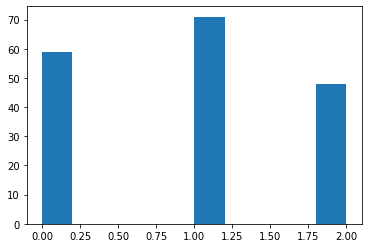

In [6]:
plt.hist(target)
plt.show()

## Splitting the data

In [7]:
# Because we shuffle and stratify, we need to pass both the data (X) and target (y), and assign them separately

X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, stratify=target, test_size=0.3)

Let's take a look at the representation of our train y-vector

In [8]:
_, stratified_counts = np.unique(y_train, return_counts=True)
stratified_counts

array([41, 50, 33])

In [9]:
r = ratios(y_train)
for ratio in r:
    print(ratio)

[1.         0.82       1.24242424]
[1.2195122  1.         1.51515152]
[0.80487805 0.66       1.        ]


In [10]:
r = ratios(y_test)
for ratio in r:
    print(ratio)

[1.         0.85714286 1.2       ]
[1.16666667 1.         1.4       ]
[0.83333333 0.71428571 1.        ]


You'll note these ratios are quite close to the original distribution. It's of course hard to do perfect as you cannot always make an even split

# Balancing the data

Let's start with just getting the indices of all the classes in our y-vector

In [11]:
class1 = np.where(y_train == 0)[0]
class2 = np.where(y_train == 1)[0]
class3 = np.where(y_train == 2)[0]

## Oversampling

In [12]:
# Which is the majority class?
print(len(class1), len(class2), len(class3))

41 50 33


In [13]:
majority = len(class2)

In [14]:
# Sample the remaining classes according to the majority size, with replacement
class1_up = np.random.choice(class1, size=majority, replace=True)
class3_up = np.random.choice(class3, size=majority, replace=True)

Next step is sampling each of the classes and making a new, balanced, dataset

In [15]:
indices = np.concatenate([class1_up, class2, class3_up])
y_train_bal = y_train[indices]
X_train_bal = X_train[indices]

X_train_bal.shape

(150, 13)

You'll notice we now have 150 samples total.

Let's print the target column

In [16]:
y_train_bal

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

And let's finally print the ratios to convince ourselves we did a good job

In [17]:
r = ratios(y_train_bal)
for ratio in r:
    print(ratio)

[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]


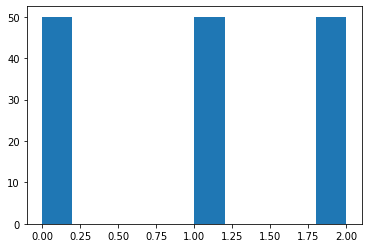

In [18]:
plt.hist(y_train_bal)
plt.show()

## Undersampling

Quite similar to above, but with the minority class

In [19]:
# Which is the minority class?
print(len(class1), len(class2), len(class3))

41 50 33


In [20]:
minority = len(class3)

In [21]:
# Sample the remaining classes according to the majority size, with replacement
class1_up = np.random.choice(class1, size=minority, replace=True)
class2_up = np.random.choice(class2, size=minority, replace=True)

Next step is sampling each of the classes and making a new, balanced, dataset

In [22]:
indices = np.concatenate([class1_up, class2_up, class3])
y_train_bal = y_train[indices]
X_train_bal = X_train[indices]

X_train_bal.shape

(99, 13)

**We now have 99 samples (33\*3), so we're using less of our dataset than in the above case.**

Let's print the target column

In [23]:
y_train_bal

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

And let's finally print the ratios to convince ourselves we did a good job

In [24]:
r = ratios(y_train_bal)
for ratio in r:
    print(ratio)

[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]


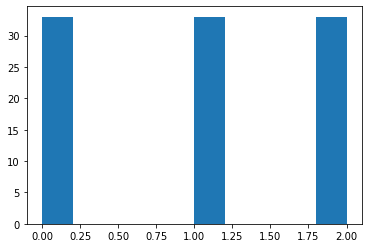

In [25]:
plt.hist(y_train_bal)
plt.show()

## Mixed Sampling

There's a few approaches.
We can either just take the middle class, as describes in the top, or we can sample according to the average representation - using the mean.

In [26]:
# What is the mean?
print("Mean sample (integer)", int(np.mean([len(class1), len(class2), len(class3)])))
print("Sample class lengths:", len(class1), len(class2), len(class3))

Mean sample (integer) 41
Sample class lengths: 41 50 33


In this case, they're one and the same. Using the mean is simpler to calculate, but bears some risk in the groups where you're close to the amount of samples but you want to sample without replacement.

So let's just simplify it by entirely sampling the middle class.

In [27]:
middle = int(np.mean([len(class1), len(class2), len(class3)]))

In [28]:
# Sample the remaining classes according to the majority size, with replacement
class2_down = np.random.choice(class2, size=middle, replace=True)
class3_up = np.random.choice(class3, size=middle, replace=True)

Next step is sampling each of the classes and making a new, balanced, dataset

In [29]:
indices = np.concatenate([class1, class2_down, class3_up])
y_train_bal = y_train[indices]
X_train_bal = X_train[indices]

X_train_bal.shape

(123, 13)

We now have 123 samples (41\*3), so we're hitting a good middle ground here.

Let's print the target column

In [30]:
y_train_bal

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

And let's finally print the ratios to convince ourselves we did a good job

In [31]:
r = ratios(y_train_bal)
for ratio in r:
    print(ratio)

[1. 1. 1.]
[1. 1. 1.]
[1. 1. 1.]


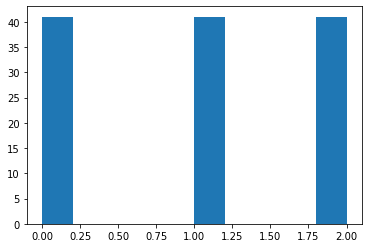

In [32]:
plt.hist(y_train_bal)
plt.show()

## Sample weights

As mentioned above, calculating the sample weights for each class is most easily done according to the ratios.

In [33]:
r = ratios(y_train)
for ratio in r:
    print(ratio)

[1.         0.82       1.24242424]
[1.2195122  1.         1.51515152]
[0.80487805 0.66       1.        ]


It shouldn't really matter which one you pick, but I prefer making my choice around 1, which means taking the ratios according to the majority. That's the second row in this instance.

In [34]:
class_ratios = r[1]
class_ratios

array([1.2195122 , 1.        , 1.51515152])

The next step is to make an array with all the sample weights

In [35]:
sample_weights = np.array([class_ratios[y] for y in y_train])
sample_weights

array([1.2195122 , 1.2195122 , 1.51515152, 1.2195122 , 1.51515152,
       1.2195122 , 1.51515152, 1.2195122 , 1.2195122 , 1.        ,
       1.        , 1.        , 1.2195122 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.2195122 ,
       1.2195122 , 1.51515152, 1.        , 1.2195122 , 1.        ,
       1.2195122 , 1.        , 1.2195122 , 1.2195122 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.51515152, 1.51515152, 1.2195122 , 1.2195122 , 1.2195122 ,
       1.        , 1.        , 1.        , 1.        , 1.2195122 ,
       1.        , 1.2195122 , 1.51515152, 1.        , 1.2195122 ,
       1.51515152, 1.51515152, 1.2195122 , 1.        , 1.2195122 ,
       1.        , 1.        , 1.        , 1.2195122 , 1.2195122 ,
       1.        , 1.51515152, 1.51515152, 1.51515152, 1.2195122 ,
       1.2195122 , 1.51515152, 1.51515152, 1.51515152, 1.51515152,
       1.2195122 , 1.51515152, 1.        , 1.2195122 , 1.51515

And then we can use these weights directly when we train a model by multiplying it to, i.e. the learning rate

Another option is to sample from the dataset using these weights, however then we first have to normalize them so they sum to 1.

You'll notice as we run this sampling for different sizes, it'll consistently be fairly close to 1, but due to the probabilistic nature it's hard to guarantee. It'll generally be more stable in its fairness on balancing the more you sample

In [36]:
def normalize(weights):
    return weights / weights.sum()

In [37]:
def sample(data, size, weights):
    return np.random.choice(y_train, size=2000, replace=True, p=normalize(sample_weights))

In [38]:
y_train_bal = sample(y_train, size=10, weights=normalize(sample_weights))
r = ratios(y_train_bal)
for ratio in r:
    print(ratio)

[1.         0.98088235 1.02143951]
[1.01949025 1.         1.04134763]
[0.97901049 0.96029412 1.        ]


In [39]:
y_train_bal = sample(y_train, size=100, weights=normalize(sample_weights))
r = ratios(y_train_bal)
for ratio in r:
    print(ratio)

[1.         0.9360119  0.89985694]
[1.06836248 1.         0.96137339]
[1.11128776 1.04017857 1.        ]


In [40]:
y_train_bal = sample(y_train, size=200, weights=normalize(sample_weights))
r = ratios(y_train_bal)
for ratio in r:
    print(ratio)

[1.         0.95461201 0.98045113]
[1.04754601 1.         1.02706767]
[1.01993865 0.97364568 1.        ]


In [41]:
y_train_bal = sample(y_train, size=1000, weights=normalize(sample_weights))
r = ratios(y_train_bal)
for ratio in r:
    print(ratio)

[1.         1.04739336 0.94176136]
[0.95475113 1.         0.89914773]
[1.06184012 1.1121643  1.        ]


In [42]:
y_train_bal = sample(y_train, size=10000, weights=normalize(sample_weights))
r = ratios(y_train_bal)
for ratio in r:
    print(ratio)

[1.         1.05965463 0.98110465]
[0.9437037  1.         0.92587209]
[1.01925926 1.08006279 1.        ]


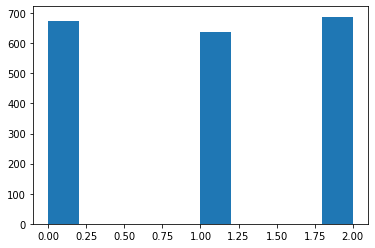

In [43]:
plt.hist(y_train_bal)
plt.show()